# EDA & Anomaly Detection - Isolation Forest

In [59]:
from datetime import timedelta

# Config
STATE = 42 # Used for consistency during development, should be removed when performing actual anomaly detection.
SERVICE = 'ServiceA'
LAMBDA = 'LambdaB'

USE_DURATION = False
METRIC = 'Duration' if USE_DURATION else 'ConcurrentExecutions' # Should be 'Duration' or 'ConcurrentExecutions'
METRIC_SLICE = None
# METRIC_SLICE = [5000, 8000] # Optional array for using only a slice of the whole metric e.g. [5000, 8000] will use df[5000:8000] later on

STL_DECOMP_PERIOD = 588 # (Int, required) Period for stl decomposition. See https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
GRAPH_GAP_TRESHOLD = timedelta(hours=2) # (Timedelta, required) Timestamp difference limit between two adjacent data points. No line is drawn between the points for greater values.
ANOMALY_NEIGHBOR_LIMIT = 1 # (Int, optional) Minimum number of anomalies in a row. Anomalies under this number are removed. 
POST_RELEASE_TRESHOLD = timedelta(days=1) # (Timedelta, optional) If defined, all anomalies after a release date within the treshold will be summed up and marked in the final graph.

In [38]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import util
import json
from sklearn.ensemble import IsolationForest

matplotlib.interactive('True')

# Metric conversion from exported CloudWatch JSON to pandas DataFrames
metrics = util.json_to_pandas(f'../ExportedMetrics/{SERVICE}/{LAMBDA}.json')
for metric in metrics:
    print(f'{metric.upper()}:\n',metrics[metric], '\n\n')
    metrics[metric].to_csv('./output/csv/ServiceALambdaB' + metric + '.csv')

DURATION:
                      Timestamps      Values
0     2020-10-17 12:35:00+00:00  136.053333
1     2020-10-17 12:40:00+00:00  173.550667
2     2020-10-17 12:45:00+00:00  176.770000
3     2020-10-17 12:50:00+00:00  139.507143
4     2020-10-17 12:55:00+00:00  139.293333
...                         ...         ...
17007 2020-12-19 10:07:00+00:00   75.800161
17008 2020-12-19 10:12:00+00:00   70.929333
17009 2020-12-19 10:17:00+00:00   69.787614
17010 2020-12-19 10:22:00+00:00   70.871408
17011 2020-12-19 10:27:00+00:00   76.694286

[17012 rows x 2 columns] 


CONCURRENTEXECUTIONS:
                      Timestamps    Values
0     2020-10-17 12:35:00+00:00  1.666667
1     2020-10-17 12:40:00+00:00  1.400000
2     2020-10-17 12:45:00+00:00  1.500000
3     2020-10-17 12:50:00+00:00  1.428571
4     2020-10-17 12:55:00+00:00  1.666667
...                         ...       ...
17007 2020-12-19 10:07:00+00:00  1.306452
17008 2020-12-19 10:12:00+00:00  1.366667
17009 2020-12-19 10:17:00+00:00

### Importing microservice release dates

In [39]:
releases = util.load_releases('../ExportedMetrics/releases.json')
releases.head(10)

,ServiceNames,Timestamps
0,ServiceA,2020-10-15 13:09:02.003799915+00:00
1,ServiceHIK,2020-10-15 14:18:49.004899979+00:00
2,ServiceB,2020-10-15 14:21:56.005199909+00:00
3,ServiceB,2020-10-19 08:30:09.000400066+00:00
4,ServiceHIK,2020-10-21 13:49:47.005199909+00:00
5,ServiceB,2020-10-22 12:20:14.000600100+00:00
6,ServiceCD,2020-10-23 14:04:43.000400066+00:00
7,ServiceB,2020-10-28 09:16:09.000900030+00:00
8,ServiceB,2020-10-28 11:33:24.003599882+00:00
9,ServiceA,2020-10-29 09:56:09.004199982+00:00


In [40]:
# Some microservices are grouped together during release
release_service_map = {
    'ServiceA': 'ServiceA',
    'ServiceB': 'ServiceB',
    'ServiceC': 'ServiceCD',
    'ServiceD': 'ServiceCD',
    'ServiceE': 'ServiceEF',
    'ServiceF': 'ServiceEF',
    'ServiceG': None,
    'ServiceH': 'ServiceHIK',
    'ServiceI': 'ServiceHIK',
    'ServiceJ': 'ServiceJ',
    'ServiceK': 'ServiceHIK'
}

service_releases = releases.loc[releases['ServiceNames'] == release_service_map[SERVICE]] if release_service_map[SERVICE] != None else None

In [41]:
try:
    df = metrics[METRIC]
except:
    import winsound
    winsound.Beep(700, 200)
    winsound.Beep(500, 200)
    winsound.Beep(250, 600)

df_test = df.copy()

### Adding feature `Release_Point` for rows right after a microservice deployment

In [42]:
df_test = util.calculate_release_point_feature(df_test, service_releases)

Earliest in-scope release date:  2020-10-17 12:40:00+00:00
Latest in-scope release date:  2020-12-19 10:27:00+00:00


### Adding feature `Post_Release` for data points within `POST_RELEASE_TRESHOLD` after a release point.

In [43]:
df_test = util.calculate_post_release_feature(df_test, POST_RELEASE_TRESHOLD)
df_test.loc[df_test.Post_Release == 1]

,Timestamps,Values,Release_Point,Post_Release
1514,2020-10-23 14:10:00+00:00,1.709091,1,1
1515,2020-10-23 14:15:00+00:00,1.559322,0,1
1516,2020-10-23 14:20:00+00:00,1.545455,0,1
1517,2020-10-23 14:25:00+00:00,1.333333,0,1
1518,2020-10-23 14:30:00+00:00,1.500000,0,1
...,...,...,...,...
6322,2020-11-10 15:45:00+00:00,1.362832,0,1
6323,2020-11-10 15:50:00+00:00,1.395062,0,1
6324,2020-11-10 15:55:00+00:00,1.271429,0,1
6325,2020-11-10 16:00:00+00:00,1.280000,0,1


In [44]:
df_test.loc[df_test['Post_Release'] == 1]

,Timestamps,Values,Release_Point,Post_Release
1514,2020-10-23 14:10:00+00:00,1.709091,1,1
1515,2020-10-23 14:15:00+00:00,1.559322,0,1
1516,2020-10-23 14:20:00+00:00,1.545455,0,1
1517,2020-10-23 14:25:00+00:00,1.333333,0,1
1518,2020-10-23 14:30:00+00:00,1.500000,0,1
...,...,...,...,...
6322,2020-11-10 15:45:00+00:00,1.362832,0,1
6323,2020-11-10 15:50:00+00:00,1.395062,0,1
6324,2020-11-10 15:55:00+00:00,1.271429,0,1
6325,2020-11-10 16:00:00+00:00,1.280000,0,1


In [45]:
df_test.loc[df_test['Release_Point'] == 1]

,Timestamps,Values,Release_Point,Post_Release
1514,2020-10-23 14:10:00+00:00,1.709091,1,1
6042,2020-11-09 15:25:00+00:00,1.274725,1,1
6050,2020-11-09 16:05:00+00:00,1.444444,1,1


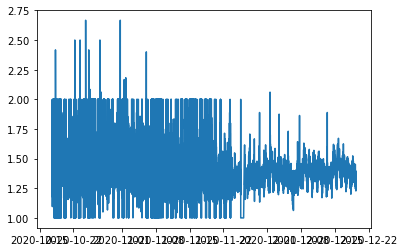

In [46]:
plt.plot(df_test.Timestamps, df_test.Values)
plt.show()

### STL Decomposition

* Note: The trend around the start and end of the time series is extrapolated, otherwise it would be missing.

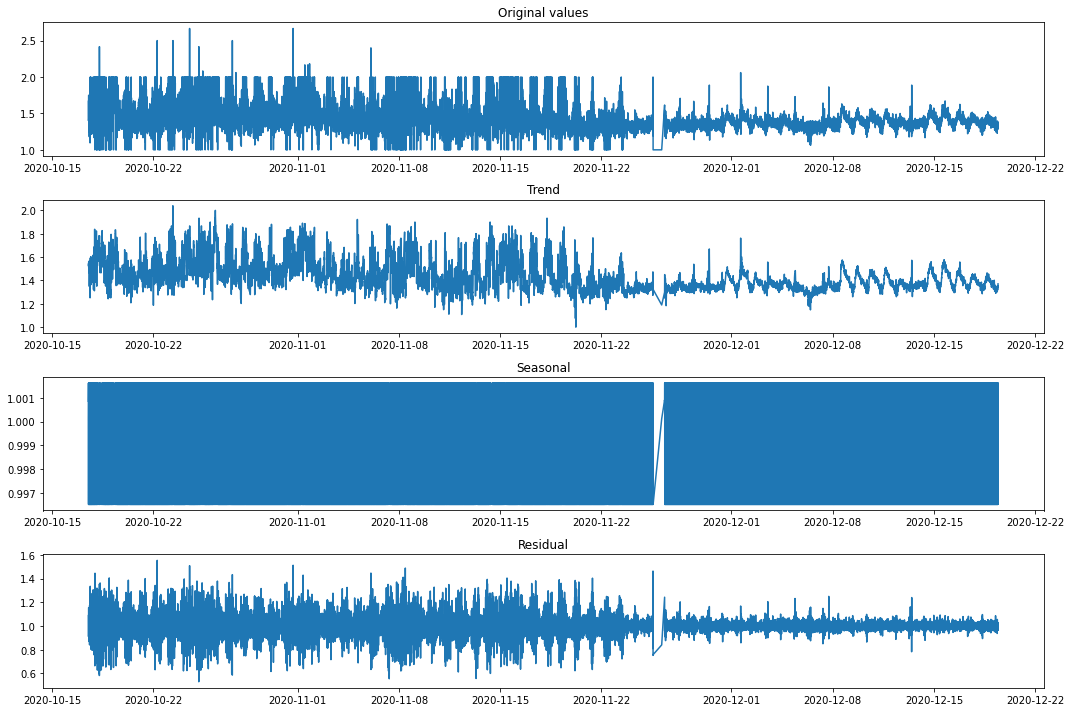

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(
    df_test.Values,
    period=STL_DECOMP_PERIOD,
    extrapolate_trend='freq',
    model='multiplicative'
)

fig, axs = plt.subplots(4,1, figsize=(15,10), sharex=False)
axs[0].plot(df_test.Timestamps, df_test.Values)
axs[0].set_title('Original values')
axs[1].plot(df_test.Timestamps, decompose_result.trend)
axs[1].set_title('Trend')
axs[2].plot(df_test.Timestamps, decompose_result.seasonal)
axs[2].set_title('Seasonal')
axs[3].plot(df_test.Timestamps, decompose_result.resid)
axs[3].set_title('Residual')
plt.tight_layout()
plt.show()

In [48]:
df_test['Trend_Values'] = decompose_result.trend
df_test['Seasonal_Values'] = decompose_result.seasonal
df_test['Residual_Values'] = decompose_result.resid
df_test.head()

,Timestamps,Values,Release_Point,Post_Release,Trend_Values,Seasonal_Values,Residual_Values
0,2020-10-17 12:35:00+00:00,1.666667,0,0,1.534726,1.014764,1.070170
1,2020-10-17 12:40:00+00:00,1.400000,0,0,1.534615,0.999481,0.912754
2,2020-10-17 12:45:00+00:00,1.500000,0,0,1.534504,0.986578,0.990814
3,2020-10-17 12:50:00+00:00,1.428571,0,0,1.534392,0.980368,0.949678
4,2020-10-17 12:55:00+00:00,1.666667,0,0,1.534281,0.979645,1.108856


### Model fitting for original values and decomposed residual values

In [49]:
model = IsolationForest(
    max_features = 1.0,
    n_estimators = 50,
    max_samples = 'auto',
    contamination = 0.01,
    random_state = STATE or None
)
model.fit(df_test[['Values']])
df_test['Values_Scores'] = model.decision_function(df_test[['Values']])
df_test['Values_Inliers'] = model.predict(df_test[['Values']])

model.fit(df_test[['Residual_Values']])
df_test['Residual_Values_Scores'] = model.decision_function(df_test[['Residual_Values']])
df_test['Residual_Values_Inliers'] = model.predict(df_test[['Residual_Values']])

print(df_test.head())

                 Timestamps    Values  Release_Point  Post_Release  \
0 2020-10-17 12:35:00+00:00  1.666667              0             0   
1 2020-10-17 12:40:00+00:00  1.400000              0             0   
2 2020-10-17 12:45:00+00:00  1.500000              0             0   
3 2020-10-17 12:50:00+00:00  1.428571              0             0   
4 2020-10-17 12:55:00+00:00  1.666667              0             0   

   Trend_Values  Seasonal_Values  Residual_Values  Values_Scores  \
0      1.534726         1.014764         1.070170       0.211639   
1      1.534615         0.999481         0.912754       0.302371   
2      1.534504         0.986578         0.990814       0.304674   
3      1.534392         0.980368         0.949678       0.302121   
4      1.534281         0.979645         1.108856       0.211639   

   Values_Inliers  Residual_Values_Scores  Residual_Values_Inliers  
0               1                0.249382                        1  
1               1               

### Cleaning up point anomalies with optional parameters

In [51]:
# Removing anomalies not part of a group at least ANOMALY_NEIGHBOR_LIMIT long
try:
    df_test = util.limit_anomalies(df_test, 'Values_Inliers', -1, 1, ANOMALY_NEIGHBOR_LIMIT)
    df_test = util.limit_anomalies(df_test, 'Residual_Values_Inliers', -1, 1,  ANOMALY_NEIGHBOR_LIMIT)
except NameError:
    print('Optional ANOMALY_NEIGHBOR_LIMIT undefined, continuing.')

Anomalies dropped for feature "Values_Inliers": 0
Anomalies dropped for feature "Residual_Values_Inliers": 0


In [52]:
values_anomaly_counts = df_test.Values_Inliers.value_counts()[-1] if -1 in df_test.Values_Inliers.value_counts() else 0
residual_values_anomaly_counts = df_test.Residual_Values_Inliers.value_counts()[-1] if -1 in df_test.Residual_Values_Inliers.value_counts() else 0
print(f'Anomalous data points from raw values: {values_anomaly_counts} / {len(df_test["Values_Inliers"])}')
print(f'Anomalous data points from decomposed residual values: {residual_values_anomaly_counts} / {len(df_test["Residual_Values_Inliers"])}')

Anomalous data points from raw values: 0 / 17012
Anomalous data points from decomposed residual values: 165 / 17012


### New feature 'Gap' for rows whose preceding row is a long time ago.

In [53]:
df_test['Gap'] = (df.Timestamps.diff() >= GRAPH_GAP_TRESHOLD).astype(int)
print(df_test.loc[df_test['Gap'] == 1])

                     Timestamps    Values  Release_Point  Post_Release  \
10368 2020-11-26 04:10:00+00:00  1.000000              0             0   
10369 2020-11-26 09:00:00+00:00  1.615385              0             0   

       Trend_Values  Seasonal_Values  Residual_Values  Values_Scores  \
10368      1.337425         1.014173         0.737256   1.110223e-16   
10369      1.337495         1.053456         1.146482   2.013544e-01   

       Values_Inliers  Residual_Values_Scores  Residual_Values_Inliers  Gap  
10368               1                0.031394                        1    1  
10369               1                0.185434                        1    1  


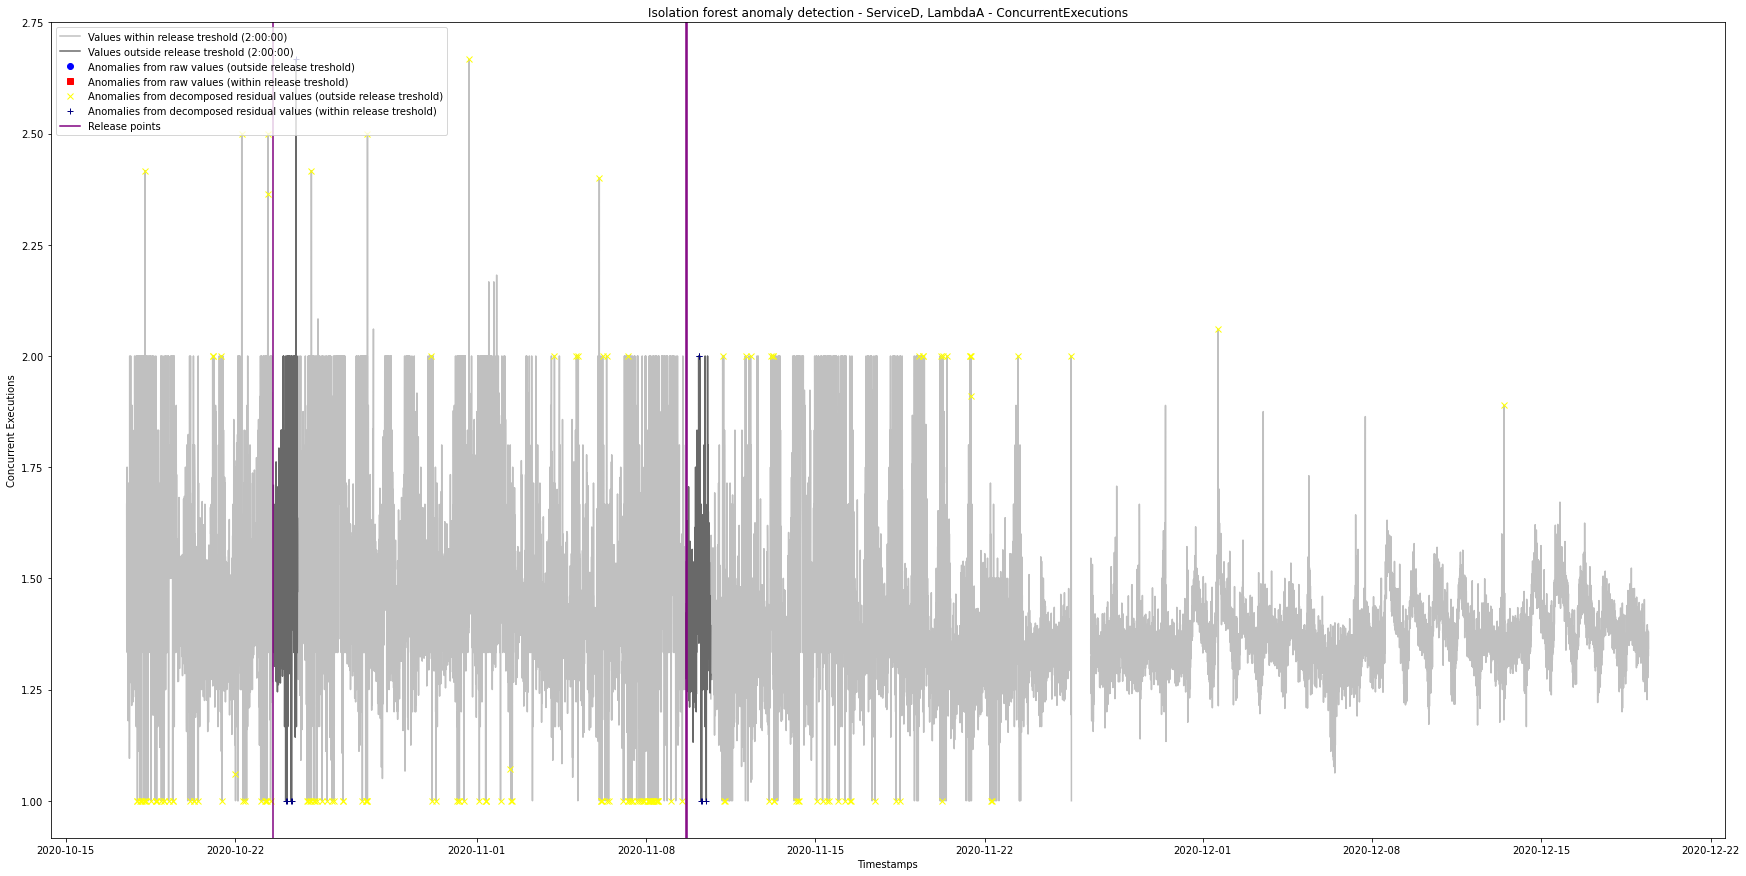

Post-release values anomalies: 0 of 0 total values anomalies
Post-release residual value anomalies: 10 of 155 total residual value anomalies


In [54]:
import numpy.ma as ma

values_inside_release_treshold = df_test.loc[df_test.Post_Release == 1]
values_outside_release_treshold = df_test.loc[df_test.Post_Release == 0]
release_points = df_test.loc[df_test.Release_Point == 1]

# Anomalies not soon after a release
values_anomalies = df_test.loc[(df_test.Values_Inliers == -1) & (df_test.Post_Release == 0)]
residual_values_anomalies = df_test.loc[(df_test.Residual_Values_Inliers == -1) & (df_test.Post_Release == 0)]

# Anomalies soon after a release
post_release_values_anomalies = df_test.loc[(df_test.Values_Inliers == -1) & (df_test.Post_Release == 1)]
post_release_residual_values_anomalies = df_test.loc[(df_test.Residual_Values_Inliers == -1) & (df_test.Post_Release == 1)]

from matplotlib.pyplot import figure
plt.figure(figsize=(30,15))
plt.xlabel("Timestamps")
plt.ylabel('Duration' if METRIC == 'Duration' else 'Concurrent Executions')


# Not close to release
mc = ma.array(df.Values.values)
mc[(df_test.Post_Release == 1) | (df_test.Gap)] = ma.masked
plt.plot(df_test.Timestamps.values, mc, color='silver')

# Close to release
mc = ma.array(df.Values.values)
mc[(df_test.Post_Release == 0) | (df_test.Gap)] = ma.masked
plt.plot(df_test.Timestamps.values, mc, color='dimgrey')

plt.plot(values_anomalies.Timestamps, values_anomalies.Values, 'o', color='blue')
plt.plot(post_release_values_anomalies.Timestamps, post_release_values_anomalies.Values, 's', color='red')
plt.plot(residual_values_anomalies.Timestamps, residual_values_anomalies.Values, 'x', color='yellow')
plt.plot(post_release_residual_values_anomalies.Timestamps, post_release_residual_values_anomalies.Values, '+', color='navy')


# Release date lines
for release in release_points.Timestamps:
    plt.axvline(release, color='purple')

plt.title(f'Isolation forest anomaly detection - {SERVICE}, {LAMBDA} - {METRIC}')
plt.legend([
    f'Values within release treshold ({POST_RELEASE_TRESHOLD})',
    f'Values outside release treshold ({POST_RELEASE_TRESHOLD})',
    'Anomalies from raw values (outside release threshold)',
    'Anomalies from raw values (within release threshold)',
    'Anomalies from decomposed residual values (outside release threshold)',
    'Anomalies from decomposed residual values (within release threshold)',
    'Release points'
], loc=2)

# plt.ylim(0, 2000)

# Output .png & .pdf files
import os

savedir = f'{os.getcwd()}\\output\\isolation-forest\\{SERVICE}\\{LAMBDA}'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plt.savefig(f'{savedir}\\{METRIC}.pdf', transparent=True, bbox_tight="inches")
plt.savefig(f'{savedir}\\{METRIC}.png')

plt.show()

print(f'Post-release values anomalies: {len(post_release_values_anomalies)} of {len(values_anomalies)} total values anomalies')
print(f'Post-release residual value anomalies: {len(post_release_residual_values_anomalies)} of {len(residual_values_anomalies)} total residual value anomalies')

In [55]:
import winsound
winsound.Beep(300, 100)
winsound.Beep(450, 100)